In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sts

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier



from scipy import stats
from prettytable import PrettyTable

In [4]:
data = pd.read_csv('data.csv')

In [5]:
data

,metric_item_label,metric_cat_label,metric_item_label_subtitle,metric_cat_item_yaxis_label,geo_label_city,geo_label_state,geo_fips_code,value,date_label,geo_label_proxy_or_real,value_95_ci_low,value_95_ci_high,geo_strata_region,geo_strata_poverty,geo_strata_Population,geo_strata_PopDensity,geo_strata_Segregation,strata_race_label,strata_sex_label,persons_or_years
0,0.0,0.0,1.0,1.0,32.0,21.0,5363.0,0.004864,2012.0,1.0,0.004610,0.005132,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,0.0,0.0,1.0,1.0,11.0,20.0,4827.0,0.009782,2011.0,1.0,0.009543,0.010025,2.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0
2,0.0,0.0,1.0,1.0,24.0,16.0,4055.0,0.003762,2012.0,1.0,0.003207,0.004393,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
3,0.0,0.0,1.0,1.0,16.0,1.0,643.0,0.006167,2012.0,1.0,0.005797,0.006558,3.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,1.0,6.0,15.0,3918.0,0.010482,2010.0,1.0,0.009922,0.011068,0.0,0.0,1.0,1.0,1.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26569,6.0,0.0,6.0,2.0,22.0,14.0,3651.0,5786.217877,2020.0,1.0,5668.487295,5903.948459,1.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0
26570,6.0,0.0,6.0,2.0,20.0,22.0,5553.0,7087.929743,2020.0,1.0,6458.346917,7717.512570,0.0,1.0,1.0,1.0,0.0,3.0,0.0,1.0
26571,6.0,0.0,6.0,2.0,12.0,20.0,4835.0,4099.348306,2011.0,1.0,3723.288703,4475.407910,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
26572,6.0,0.0,6.0,2.0,20.0,22.0,5553.0,5706.528569,2014.0,1.0,4594.357077,6818.700061,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0


Function for scores and ROC curve with corss-validation

In [6]:
def scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

In [7]:

def perso_roc(test, X, y):
    y_pred_proba_cv = cross_val_predict(test, X, y, cv=5, method='predict_proba')

    #ROC and AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(np.unique(y))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y == i).astype(int), y_pred_proba_cv[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # ROC Plot
    plt.figure()
    colors = plt.cm.get_cmap('tab10', n_classes)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors(i), label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - OvR')
    plt.legend(loc='lower right')

### PCA Feature Selection

In [8]:
X = data.drop('metric_item_label', axis = 1)
y = data['metric_item_label']

In [9]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [11]:
data_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
data_pca['metric_item_label'] = y

In [12]:
unique_labels = data_pca['metric_item_label'].unique()
num_labels = len(unique_labels)
colors = plt.cm.get_cmap('viridis', num_labels)

In [13]:
label_color_map = dict(zip(unique_labels, colors(range(num_labels))))

In [14]:
column_name_mapping= {
    0: 'Deaths from All Causes',
    1: 'Firearm Deaths',
    2: 'Infant Deaths',
    3: 'Injury Deaths',
    4: 'Maternal Deaths',
    5: 'Motor Vehicle Deaths',
    6: 'Premature Death',
}

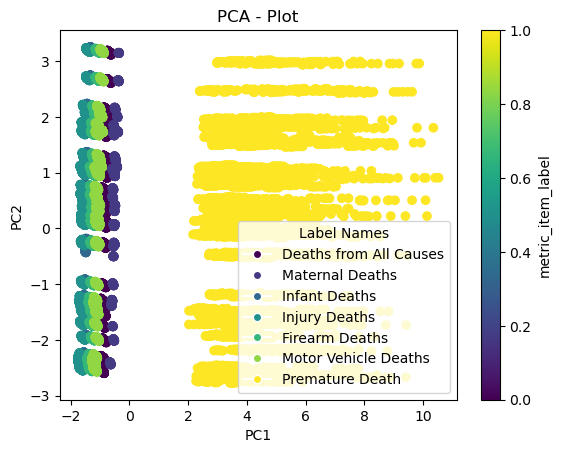

In [15]:
scatter = plt.scatter(data_pca['PC1'], data_pca['PC2'], c=data_pca['metric_item_label'].map(label_color_map), cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - Plot')
plt.colorbar(scatter, label='metric_item_label')

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=column_name_mapping[label], markerfacecolor=color) for label, color in label_color_map.items()]
plt.legend(handles=legend_elements, title='Label Names')

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

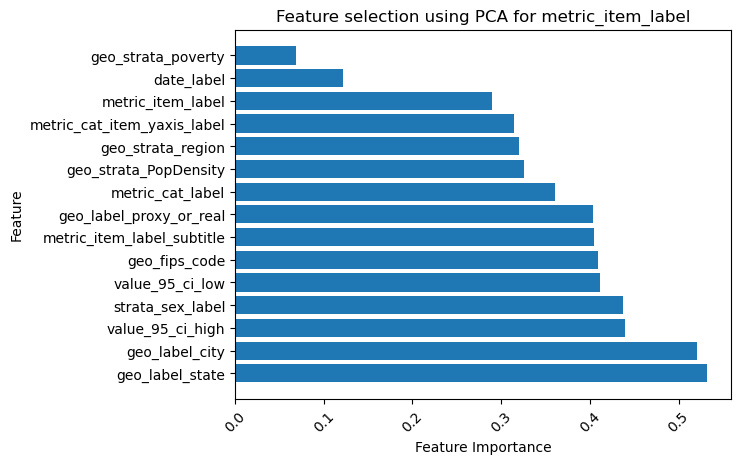

In [16]:
feature_importance = np.abs(pca.components_)
feature_importance_sum = np.sum(feature_importance, axis=0)

feature_importance_normalized = feature_importance_sum / np.sum(feature_importance_sum)
sorted_indices = np.argsort(feature_importance_normalized)[::-1]


top_10_features = data.columns[:-1][sorted_indices[:15]]

plt.barh(top_10_features, feature_importance_sum[sorted_indices[:15]])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature selection using PCA for metric_item_label')
plt.xticks(rotation=45)

### Random Forest Model

In [17]:
y = data['metric_item_label']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

Changing Hyperparameters

In [19]:
RF = RandomForestClassifier(n_estimators=3, max_depth=3, max_samples=15, class_weight='balanced')
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_test)

In [20]:
y_pred_proba_rf = RF.predict_proba(X_test) 
auc_RF = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr')

In [21]:
accuracy_RF, precision_RF, recall_RF, f1_RF = scores(y_test, y_pred_RF)

print(f"Accuracy: {accuracy_RF}")
print(f"Precision: {precision_RF}")
print(f"Recall: {recall_RF}")
print(f"F1 Score: {f1_RF}")

Accuracy: 0.5219190968955786
Precision: 0.4861695385410974
Recall: 0.5219190968955786
F1 Score: 0.4742860207873502


Text(0.5, 1.0, 'ROC: PCA - Random Forest')

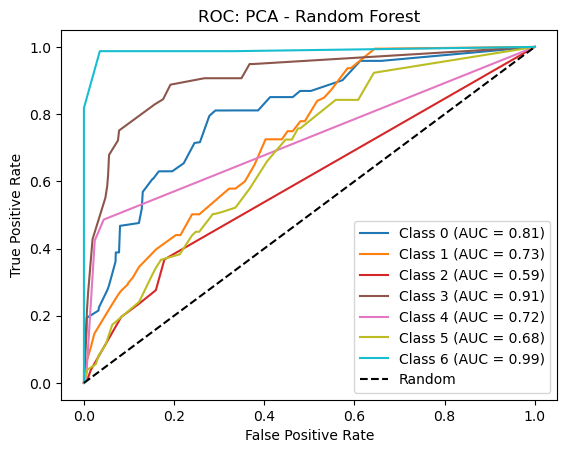

In [22]:
perso_roc(RF, X_pca, y)
plt.title('ROC: PCA - Random Forest')

### Logistic Regression Model

In [23]:
LogReg = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=2, penalty='l2', class_weight='balanced')

In [24]:
LogReg.fit(X_train, y_train)
y_pred_LogReg = LogReg.predict(X_test)

In [25]:
y_pred_proba_LR = LogReg.predict_proba(X_test) 
auc_LogReg = roc_auc_score(y_test, y_pred_proba_LR, multi_class='ovr')

In [26]:
accuracy_LogReg, precision_LogReg, recall_LogReg, f1_LogReg = scores(y_test, y_pred_LogReg)

print(f"Accuracy: {accuracy_LogReg}")
print(f"Precision: {precision_LogReg}")
print(f"Recall: {recall_LogReg}")
print(f"F1 Score: {f1_LogReg}")

Accuracy: 0.8730009407337723
Precision: 0.8709610382465551
Recall: 0.8730009407337723
F1 Score: 0.8566318483450223


Text(0.5, 1.0, 'ROC: PCA - Logistic Regression')

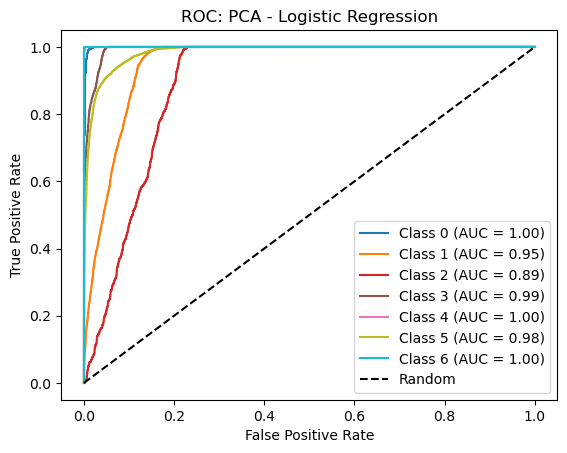

In [27]:
perso_roc(LogReg, X_pca, y)
plt.title('ROC: PCA - Logistic Regression')

### Decision Tree Model

In [28]:
DT = DecisionTreeClassifier(max_depth=2, min_samples_split=30, max_features=2)
DT.fit(X_train ,y_train)

y_pred_DT = DT.predict(X_test)

In [29]:
y_pred_proba_DT = DT.predict_proba(X_test) 
auc_DT = roc_auc_score(y_test, y_pred_proba_DT, multi_class='ovr')

In [30]:
accuracy_DT, precision_DT, recall_DT, f1_DT = scores(y_test, y_pred_DT)

print(f"Accuracy: {accuracy_DT}")
print(f"Precision: {precision_DT}")
print(f"Recall: {recall_DT}")
print(f"F1 Score: {f1_DT}")

Accuracy: 0.6126058325493885
Precision: 0.45352783488001946
Recall: 0.6126058325493885
F1 Score: 0.5022461921909753


Text(0.5, 1.0, 'ROC: PCA - Decision Tree')

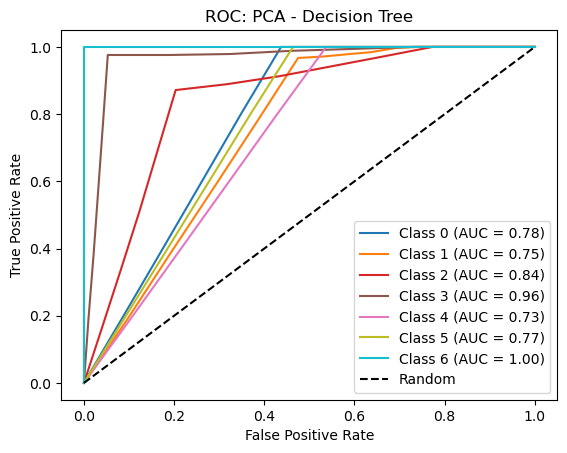

In [31]:
perso_roc(DT, X_pca, y)
plt.title('ROC: PCA - Decision Tree')

### Using KNN model

In [32]:
knn = KNeighborsClassifier(n_neighbors=5000, algorithm='kd_tree')

knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

y_pred_proba_knn = knn.predict_proba(X_test) 

auc_knn = roc_auc_score(y_test, y_pred_proba_knn, multi_class='ovr')

y_pred_knn = knn.predict(X_test)

In [33]:
accuracy_knn, precision_knn, recall_knn, f1_knn = scores(y_test, y_pred_knn)

print(f"Accuracy: {accuracy_knn}")
print(f"Precision: {precision_knn}")
print(f"Recall: {recall_knn}")
print(f"F1 Score: {f1_knn}")


Accuracy: 0.6203198494825964
Precision: 0.6680392472318405
Recall: 0.6203198494825964
F1 Score: 0.49934577801586905


Text(0.5, 1.0, 'ROC: PCA - K Nearest Neighbour')

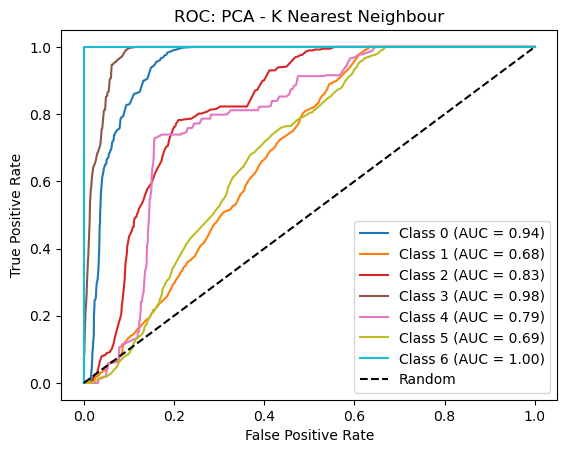

In [34]:
perso_roc(knn, X_pca, y)
plt.title('ROC: PCA - K Nearest Neighbour')

### Scores

In [35]:
model_names = ['RF', 'LogReg', 'KNN', 'DT']
accuracy_scores = [accuracy_RF, accuracy_LogReg, accuracy_knn, accuracy_DT]
precision_scores = [precision_RF, precision_LogReg, precision_knn, precision_DT]
recall_scores = [recall_RF, recall_LogReg, recall_knn, recall_DT]
f1_scores = [f1_RF, f1_LogReg, f1_knn, f1_DT]

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

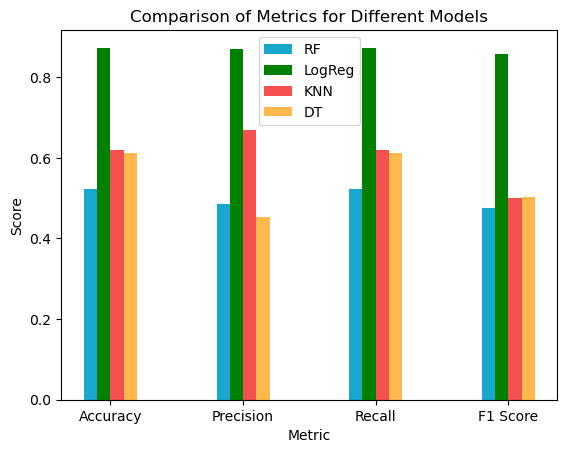

In [36]:
x = np.arange(len(metric_names))

bar_width = 0.1

color_map = {'RF': '#19A7CE', 'LogReg': 'green', 'KNN': '#F45050', 'DT': '#FFB84C'}

fig, ax = plt.subplots()

for i, model_name in enumerate(model_names):
    model_scores = [accuracy_scores[i], precision_scores[i], recall_scores[i], f1_scores[i]]
    bar_positions = x + (i * bar_width)
    ax.bar(bar_positions, model_scores, bar_width, label=model_name, color=color_map[model_name])

ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Comparison of Metrics for Different Models')
ax.set_xticks(x + (bar_width * 1.5))
ax.set_xticklabels(metric_names)
ax.legend()

In [37]:
models = ['Random Forest', 'Decision Tree', 'Logistic Regression', 'KNN']
auc_values = [auc_RF, auc_DT, auc_LogReg, auc_knn]

Random Forest AUC: 0.7987947250470292
Decision Tree AUC: 0.9312375590244807
Logistic Regression AUC: 0.9861225986435616
KNN AUC: 0.8472510069601682


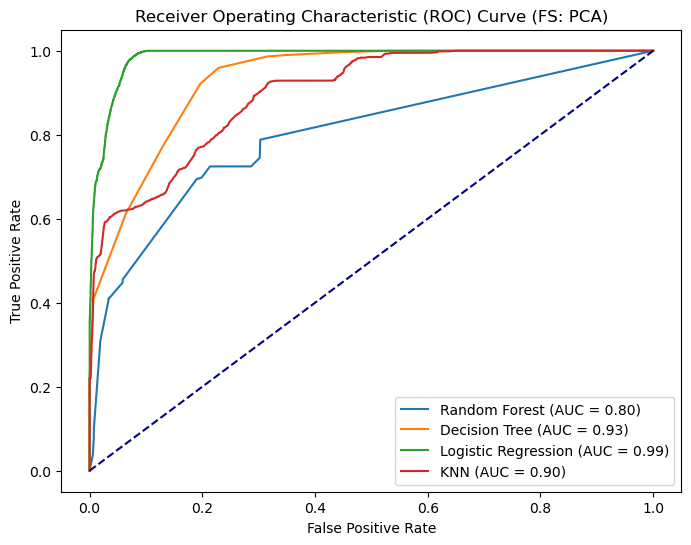

In [38]:
# Random Forest
y_pred_rf = RF.predict_proba(X_test)  # Assuming rf is your trained Random Forest model
fpr_rf, tpr_rf, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_rf.ravel())
auc_rf = auc(fpr_rf, tpr_rf)
print(f"Random Forest AUC: {auc_rf}")

# Decision Tree
y_pred_dt = DT.predict_proba(X_test)  # Assuming dt is your trained Decision Tree model
fpr_dt, tpr_dt, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_dt.ravel())
auc_dt = auc(fpr_dt, tpr_dt)
print(f"Decision Tree AUC: {auc_dt}")

# Logistic Regression
y_pred_lr = LogReg.predict_proba(X_test)  # Assuming lr is your trained Logistic Regression model
fpr_lr, tpr_lr, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_lr.ravel())
auc_lr = auc(fpr_lr, tpr_lr)
print(f"Logistic Regression AUC: {auc_lr}")

# SVC
decision_scores_svc = knn.predict_proba(X_test)
fpr_knn, tpr_knn, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), decision_scores_svc.ravel())
auc_svc = auc(fpr_knn, tpr_knn)
print(f"KNN AUC: {auc_knn}")


# Plotting the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.2f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {auc_svc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (FS: PCA)')
plt.legend(loc='lower right')
